# Joint Diffusion training

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import fsspec
import os
import sys
import dask
from dataclasses import dataclass, asdict, field
sys.path.append(os.path.abspath(os.path.join('diffusionsim')))
import gcsfs
fs = gcsfs.GCSFileSystem()

user_path = "gs://leap-persistent/sammyagrawal"

fs.ls(user_path)

['leap-persistent/sammyagrawal/input_climsim.npy',
 'leap-persistent/sammyagrawal/output_climsim.npy']

In [3]:
import diffusers
import diffusionsim as diff
import diffusionsim.training_utils as tru
from diffusionsim import mydatasets as data
import xbatcher

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Standard Training Pipeline (no diffusion)

In [40]:
dconfig = tru.DataConfig()
dconfig.dataloader_params.batch_size = 256 
dconfig.dataloader_params.pin_memory = False
dconfig.train_test_split=[0.70, 0.30]


In [5]:
X, Y = diff.load_numpy_arrays()
Xarr, Yarr = diff.reconstruct_xarr_from_npy(
    X, Y, 
    subsampling= dconfig.xarr_subsamples, 
    data_vars=dconfig.data_vars, 
)

Finished Loading X from gs://leap-persistent/sammyagrawal/input_climsim.npy
Finished Loading Y from gs://leap-persistent/sammyagrawal/output_climsim.npy


In [6]:
(xtrain, ytrain), (xtest, ytest) = data.train_test_split(Xarr, Yarr, split_frac= dconfig.train_test_split, typ="np")


In [9]:
train_ds = data.ClimsimDataset(xtrain, ytrain, normalize=False)
test_ds = data.ClimsimDataset(xtest, ytest, normalize=False)

In [10]:
train_ds.X = (train_ds.X - train_ds.X.mean(dim=0)) / train_ds.X.std(dim=0)
train_ds.Y = (train_ds.Y - train_ds.Y.mean(dim=0)) / train_ds.Y.std(dim=0)

x, y = train_ds[0]
test_ds.X = (test_ds.X - test_ds.X.mean(dim=0)) / train_ds.X.std(dim=0)
test_ds.Y = (test_ds.Y - test_ds.Y.mean(dim=0)) / train_ds.Y.std(dim=0)

In [54]:
loss_fn = nn.MSELoss()

In [58]:
tconfig = tru.TrainingConfig()
tconfig.num_epochs = 10
tconfig.learning_rate = 0.0005
tconfig.batch_checkpoint_interval = 5

In [59]:
exp_id = "JointTraining"
tconfig.log_id = os.path.join("experiments", exp_id)
tconfig.ckpt_id = os.path.join(tconfig.log_id, "vanilla.pt")

In [60]:
tconfig.ckpt_id

'experiments/JointTraining/vanilla.pt'

In [32]:
def evaluate(model):
    model.eval()
    with torch.no_grad():
        total_loss = loss_fn(model(test_ds.X), test_ds.Y)
        return(total_loss / test_ds.Y.shape[0])

In [61]:
def vanilla_train(model, dataset, loss_fn, tconfig):
    dataloader = torch.utils.data.DataLoader(dataset, **asdict(dconfig.dataloader_params))
    optimizer = torch.optim.Adam(model.parameters(), lr=tconfig.learning_rate, weight_decay=1e-4)
    losses = dict(train=[], test=[])
    for epoch in range(1, tconfig.num_epochs+1):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for x, y in dataloader:
            #x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        # Print training progress
        average_loss = running_loss / len(dataloader)
        test_loss = evaluate(model).item()
        print(f'Epoch [{epoch}/{tconfig.num_epochs}], Train Loss: {average_loss:.4f}, Test Loss: {test_loss:.4f}')
        losses['train'].append(average_loss); losses['test'].append(test_loss);
        if(epoch % tconfig.batch_checkpoint_interval == 0):
            print("Saving Model")
            torch.save(model.state_dict(), tconfig.ckpt_id)

    return(model, losses)

In [62]:
model = nn.Sequential(
    nn.Linear(in_features=124, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
).to(device)

In [35]:
evaluate(model)

tensor(0.0110, device='cuda:0')

In [63]:
model, losses = vanilla_train(model, train_ds, loss_fn, tconfig)

Epoch [1/10], Train Loss: 0.0505, Test Loss: 0.0336
Epoch [2/10], Train Loss: 0.0204, Test Loss: 0.0393
Epoch [3/10], Train Loss: 0.0180, Test Loss: 0.0469
Epoch [4/10], Train Loss: 0.0170, Test Loss: 0.0483
Epoch [5/10], Train Loss: 0.0164, Test Loss: 0.0500
Saving Model
Epoch [6/10], Train Loss: 0.0160, Test Loss: 0.0531
Epoch [7/10], Train Loss: 0.0158, Test Loss: 0.0555
Epoch [8/10], Train Loss: 0.0155, Test Loss: 0.0577
Epoch [9/10], Train Loss: 0.0154, Test Loss: 0.0591
Epoch [10/10], Train Loss: 0.0152, Test Loss: 0.0607
Saving Model


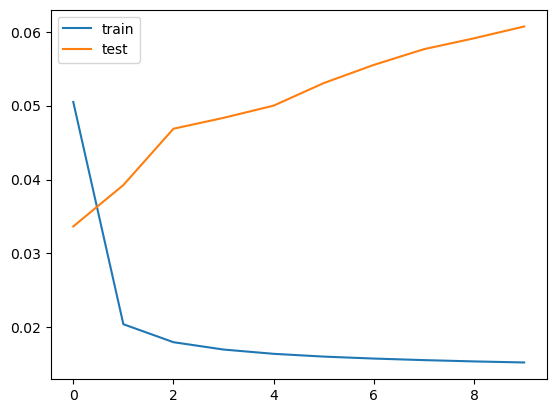

In [64]:
plt.plot(losses['train'], label='train')
plt.plot(losses['test'], label='test')
plt.legend()
plt.show()

## Diffusion Augmented training

In [33]:
exp_id = "full_dataset_testrun"
base_dir = os.path.join("experiments", exp_id)
run_id = "trial_1b"
tconfig, mconfig, dconfig = tru.load_config(run_id, exp_id)

dconfig.dataset_type = "ClimsimImageDataset"
dconfig.train_test_split = [0.02, 0.01]
dconfig.dataloader_params.batch_size = 256
dconfig.dataloader_params


TrainLoaderParams(batch_size=256, shuffle=True, num_workers=8, prefetch_factor=4, persistent_workers=True, multiprocessing_context='forkserver', pin_memory=True)

In [35]:
train_ds, test_ds = data.load_dataset(dconfig, log=False)

In [41]:
from dask.diagnostics import ProgressBar

In [47]:
with ProgressBar():
    train_ds.X.load()

[########################################] | 100% Completed | 177.12 s


In [48]:
with ProgressBar():
    train_ds.Y.load()

[########################################] | 100% Completed | 184.48 s


In [83]:
with ProgressBar():
    test_ds.X.load()

[########################################] | 100% Completed | 171.33 s


In [90]:
test_ds.Y.nbytes / 1e6

826.549248

In [98]:
#with ProgressBar():
#    test_ds.Y = test_ds.Y.compute()

In [7]:
ddpm = tru.load_model_from_ckpt(f"{run_id}-ckpt.pt", mconfig, exp_id).to(device)
mconfig.scheduler_type = "ddim"
scheduler = data.load_scheduler(mconfig)
scheduler.set_timesteps(num_inference_steps=mconfig.scheduler_inference_steps)
ddpm.device

device(type='cuda', index=0)

In [8]:
scheduler.timesteps

tensor([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82,
        81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64,
        63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46,
        45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28,
        27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,
         9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [49]:
%%time
x, y = train_ds[0]

CPU times: user 505 ms, sys: 775 ms, total: 1.28 s
Wall time: 1.18 s


In [52]:
model = nn.Sequential(
    nn.Linear(in_features=124, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
).to(device)

In [14]:
y_hat = model(x.to(device))

In [15]:
def construct_image(ytensor):
    # more complex in actual setup
    return(torch.transpose(ytensor, 1, 2).reshape(-1, 128, 16, 24))

In [103]:
loss_fn = nn.MSELoss()
def image_loss(y, yhat, T: int, unet=ddpm, scheduler=scheduler):
    y, yhat = construct_image(y), construct_image(yhat)
    def encode(sample):
        eps = torch.randn(sample.shape, device=device) # BS x C x H x W
        xt = scheduler.add_noise(sample, eps, torch.LongTensor([T])) # noisy image
        return(xt)
    def decode(xt):
        for t in range(T, 0, -1):
            with torch.no_grad():
                eps_theta = unet(xt, t).sample
            xt = scheduler.step(eps_theta, t, xt).prev_sample
        return(xt)
    yhat = decode(encode(yhat))
    return(loss_fn(y, yhat))

In [54]:
image_loss(y.to(device), y_hat, 25)

tensor(1.4329, device='cuda:0', grad_fn=<MseLossBackward0>)

In [62]:
4204/256

16.421875

In [69]:
tconfig.num_epochs

20

In [72]:

len(test_ds)

8

In [80]:
%%time
c, d = train_ds[5]

CPU times: user 437 ms, sys: 1.85 ms, total: 438 ms
Wall time: 402 ms


In [81]:
%%time
loss_fn(model(a.to(device)), b.to(device))

CPU times: user 29.9 ms, sys: 0 ns, total: 29.9 ms
Wall time: 29.5 ms


tensor(0.9858, device='cuda:0', grad_fn=<MseLossBackward0>)

In [76]:
def evaluate_diff(model):
    loss = 0.0
    model.eval()
    with torch.no_grad():
        for idx in range(len(test_ds)):
            print(idx, end=" ")
            x, y = test_ds[idx]
            x, y = x.to(device), y.to(device)
            loss += loss_fn(model(x), y).item()
    return(loss / len(test_ds))

In [107]:
scheduler.timesteps

tensor([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82,
        81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64,
        63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46,
        45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28,
        27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,
         9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [121]:
def diffusion_train(model, dataset, loss_fn, tconfig):
    optimizer = torch.optim.Adam(model.parameters(), lr=tconfig.learning_rate, weight_decay=1e-4)
    losses = dict(train=[], diffusion=[], test=[])
    for epoch in range(1, tconfig.num_epochs+1):
        model.train()  # Set the model to training mode
        pixel_loss, img_loss = 0.0, 0.0
        for idx in range(len(dataset)):
            print(idx, end=" ")
            x, y = dataset[idx]
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            ploss = loss_fn(y, y_hat)
            iloss = image_loss(y, y_hat, T=25)
            (ploss + iloss).backward()
            optimizer.step()
            pixel_loss += ploss.item(); img_loss += iloss.item()
            losses['train'].append(ploss.item()); losses['diffusion'].append(iloss.item());
        # Print training progress
        #average_loss = running_loss / len(dataloader)
        #test_loss = evaluate(model).item()
        print(f'\nEpoch [{epoch}/{tconfig.num_epochs}], Pixel Loss: {pixel_loss/len(dataset):.4f}, Image Loss: {img_loss/len(dataset):.4f}')
        
        if(epoch % tconfig.batch_checkpoint_interval == 0):
            print("Saving Model")
            torch.save(model.state_dict(), tconfig.ckpt_id)

    return(model, losses)

In [116]:
model = nn.Sequential(
    nn.Linear(in_features=124, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
).to(device)

In [122]:
loss_fn(model(x.to(device)), y.to(device))

tensor(1.3941, device='cuda:0', grad_fn=<MseLossBackward0>)

In [123]:
x, y = train_ds[0]

In [127]:
model, losses = diffusion_train(model, train_ds, loss_fn, tconfig)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [1/10], Pixel Loss: 1.0640, Image Loss: 1.0884
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [2/10], Pixel Loss: 1.0268, Image Loss: 1.0556
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [3/10], Pixel Loss: 0.9956, Image Loss: 1.0274
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [4/10], Pixel Loss: 0.9671, Image Loss: 1.0011
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [5/10], Pixel Loss: 0.9403, Image Loss: 0.9758
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [6/10], Pixel Loss: 0.9146, Image Loss: 0.9515
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [7/10], Pixel Loss: 0.8901, Image Loss: 0.9280
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [8/10], Pixel Loss: 0.8668, Image Loss: 0.9055
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [9/10], Pixel Loss: 0.8446, Image Loss: 0.8840
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Epoch [10/10], Pixel Loss: 0.8236, Image Loss: 0.8637


In [130]:
torch.save(model.state_dict(), "experiments/JointTraining/diffusion_train.pt")

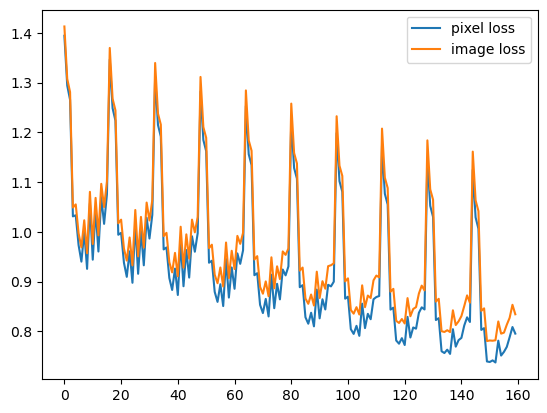

In [134]:
plt.plot(losses['train'], label='pixel loss')
plt.plot(losses['diffusion'], label='image loss')
plt.legend()
plt.show()

In [137]:
import json

In [139]:
with open("experiments/JointTraining/diffusion_train_losses.json", "w") as file:
    json.dump(losses, file)